# Rejection Sampling: A Fundamental Monte Carlo Method

## Introduction

Rejection sampling (also known as the acceptance-rejection method) is a fundamental Monte Carlo technique for generating samples from a probability distribution $f(x)$ when direct sampling is difficult or impossible. The method was introduced by John von Neumann in 1951 and remains one of the most important tools in computational statistics.

## Theoretical Foundation

### Problem Statement

Suppose we wish to sample from a target probability density function $f(x)$ but cannot do so directly. Instead, we have access to:

1. A **proposal distribution** $g(x)$ from which we can easily sample
2. A **scaling constant** $M \geq 1$ such that $f(x) \leq M \cdot g(x)$ for all $x$ in the support

### The Algorithm

The rejection sampling algorithm proceeds as follows:

1. Generate a sample $x$ from the proposal distribution $g(x)$
2. Generate $u \sim \text{Uniform}(0, 1)$
3. Accept $x$ if $u \leq \frac{f(x)}{M \cdot g(x)}$; otherwise reject and return to step 1

### Mathematical Justification

The validity of rejection sampling follows from the fundamental theorem:

**Theorem:** If $X$ is accepted by the rejection sampling algorithm, then $X \sim f(x)$.

**Proof:** The probability of accepting a point $(x, u)$ drawn from the proposal is:

$$P(\text{accept} | X = x) = P\left(U \leq \frac{f(x)}{M \cdot g(x)}\right) = \frac{f(x)}{M \cdot g(x)}$$

The marginal probability of acceptance is:

$$P(\text{accept}) = \int_{-\infty}^{\infty} \frac{f(x)}{M \cdot g(x)} g(x) dx = \frac{1}{M} \int_{-\infty}^{\infty} f(x) dx = \frac{1}{M}$$

By Bayes' theorem, the density of accepted samples is:

$$p(x | \text{accept}) = \frac{P(\text{accept} | X = x) \cdot g(x)}{P(\text{accept})} = \frac{\frac{f(x)}{M \cdot g(x)} \cdot g(x)}{\frac{1}{M}} = f(x)$$

### Efficiency Considerations

The **acceptance rate** of the algorithm is $\frac{1}{M}$. Thus:

- Smaller values of $M$ lead to more efficient sampling
- The optimal choice of $g(x)$ minimizes $M$ while maintaining $f(x) \leq M \cdot g(x)$
- The expected number of proposals needed to generate one sample is $M$

## Implementation

We will demonstrate rejection sampling by generating samples from a Beta(2.5, 5) distribution using a uniform proposal distribution.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import gamma

# Set random seed for reproducibility
np.random.seed(42)

# Define the target distribution: Beta(alpha, beta)
alpha = 2.5
beta_param = 5.0

def target_pdf(x):
    """Beta distribution PDF."""
    if np.isscalar(x):
        if x < 0 or x > 1:
            return 0.0
    else:
        result = np.zeros_like(x, dtype=float)
        mask = (x >= 0) & (x <= 1)
        x_valid = x[mask]
        B = gamma(alpha) * gamma(beta_param) / gamma(alpha + beta_param)
        result[mask] = (x_valid ** (alpha - 1)) * ((1 - x_valid) ** (beta_param - 1)) / B
        return result
    
    B = gamma(alpha) * gamma(beta_param) / gamma(alpha + beta_param)
    return (x ** (alpha - 1)) * ((1 - x) ** (beta_param - 1)) / B

# Proposal distribution: Uniform(0, 1)
def proposal_pdf(x):
    """Uniform distribution PDF on [0, 1]."""
    if np.isscalar(x):
        return 1.0 if 0 <= x <= 1 else 0.0
    return np.where((x >= 0) & (x <= 1), 1.0, 0.0)

def sample_proposal():
    """Sample from the proposal distribution."""
    return np.random.uniform(0, 1)

# Find the scaling constant M
# For Beta distribution, the mode is at x = (alpha - 1) / (alpha + beta - 2)
x_mode = (alpha - 1) / (alpha + beta_param - 2)
M = target_pdf(x_mode) / proposal_pdf(x_mode)

print(f"Target distribution: Beta({alpha}, {beta_param})")
print(f"Proposal distribution: Uniform(0, 1)")
print(f"Mode of target: x = {x_mode:.4f}")
print(f"Scaling constant M = {M:.4f}")
print(f"Expected acceptance rate: {1/M:.4f}")

Target distribution: Beta(2.5, 5.0)
Proposal distribution: Uniform(0, 1)
Mode of target: x = 0.2727
Scaling constant M = 2.3370
Expected acceptance rate: 0.4279


In [2]:
def rejection_sampling(n_samples, target, proposal_sampler, proposal_pdf, M):
    """
    Perform rejection sampling.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    target : callable
        Target PDF
    proposal_sampler : callable
        Function to sample from proposal distribution
    proposal_pdf : callable
        Proposal PDF
    M : float
        Scaling constant
    
    Returns:
    --------
    samples : ndarray
        Array of accepted samples
    n_proposals : int
        Total number of proposals made
    accepted_points : list
        List of (x, u*M*g(x)) for accepted points
    rejected_points : list
        List of (x, u*M*g(x)) for rejected points
    """
    samples = []
    n_proposals = 0
    accepted_points = []
    rejected_points = []
    
    while len(samples) < n_samples:
        # Step 1: Sample from proposal
        x = proposal_sampler()
        n_proposals += 1
        
        # Step 2: Sample uniform for acceptance test
        u = np.random.uniform(0, 1)
        
        # Step 3: Accept/reject
        acceptance_threshold = target(x) / (M * proposal_pdf(x))
        y_point = u * M * proposal_pdf(x)
        
        if u <= acceptance_threshold:
            samples.append(x)
            if len(accepted_points) < 500:  # Store limited points for visualization
                accepted_points.append((x, y_point))
        else:
            if len(rejected_points) < 500:
                rejected_points.append((x, y_point))
    
    return np.array(samples), n_proposals, accepted_points, rejected_points

# Generate samples
n_samples = 10000
samples, n_proposals, accepted_pts, rejected_pts = rejection_sampling(
    n_samples, target_pdf, sample_proposal, proposal_pdf, M
)

actual_acceptance_rate = n_samples / n_proposals
print(f"\nGenerated {n_samples} samples")
print(f"Total proposals: {n_proposals}")
print(f"Actual acceptance rate: {actual_acceptance_rate:.4f}")
print(f"Theoretical acceptance rate: {1/M:.4f}")


Generated 10000 samples
Total proposals: 23245
Actual acceptance rate: 0.4302
Theoretical acceptance rate: 0.4279


## Visualization

We now create visualizations to illustrate:
1. The geometry of rejection sampling
2. The histogram of samples compared to the true distribution
3. Convergence of sample statistics

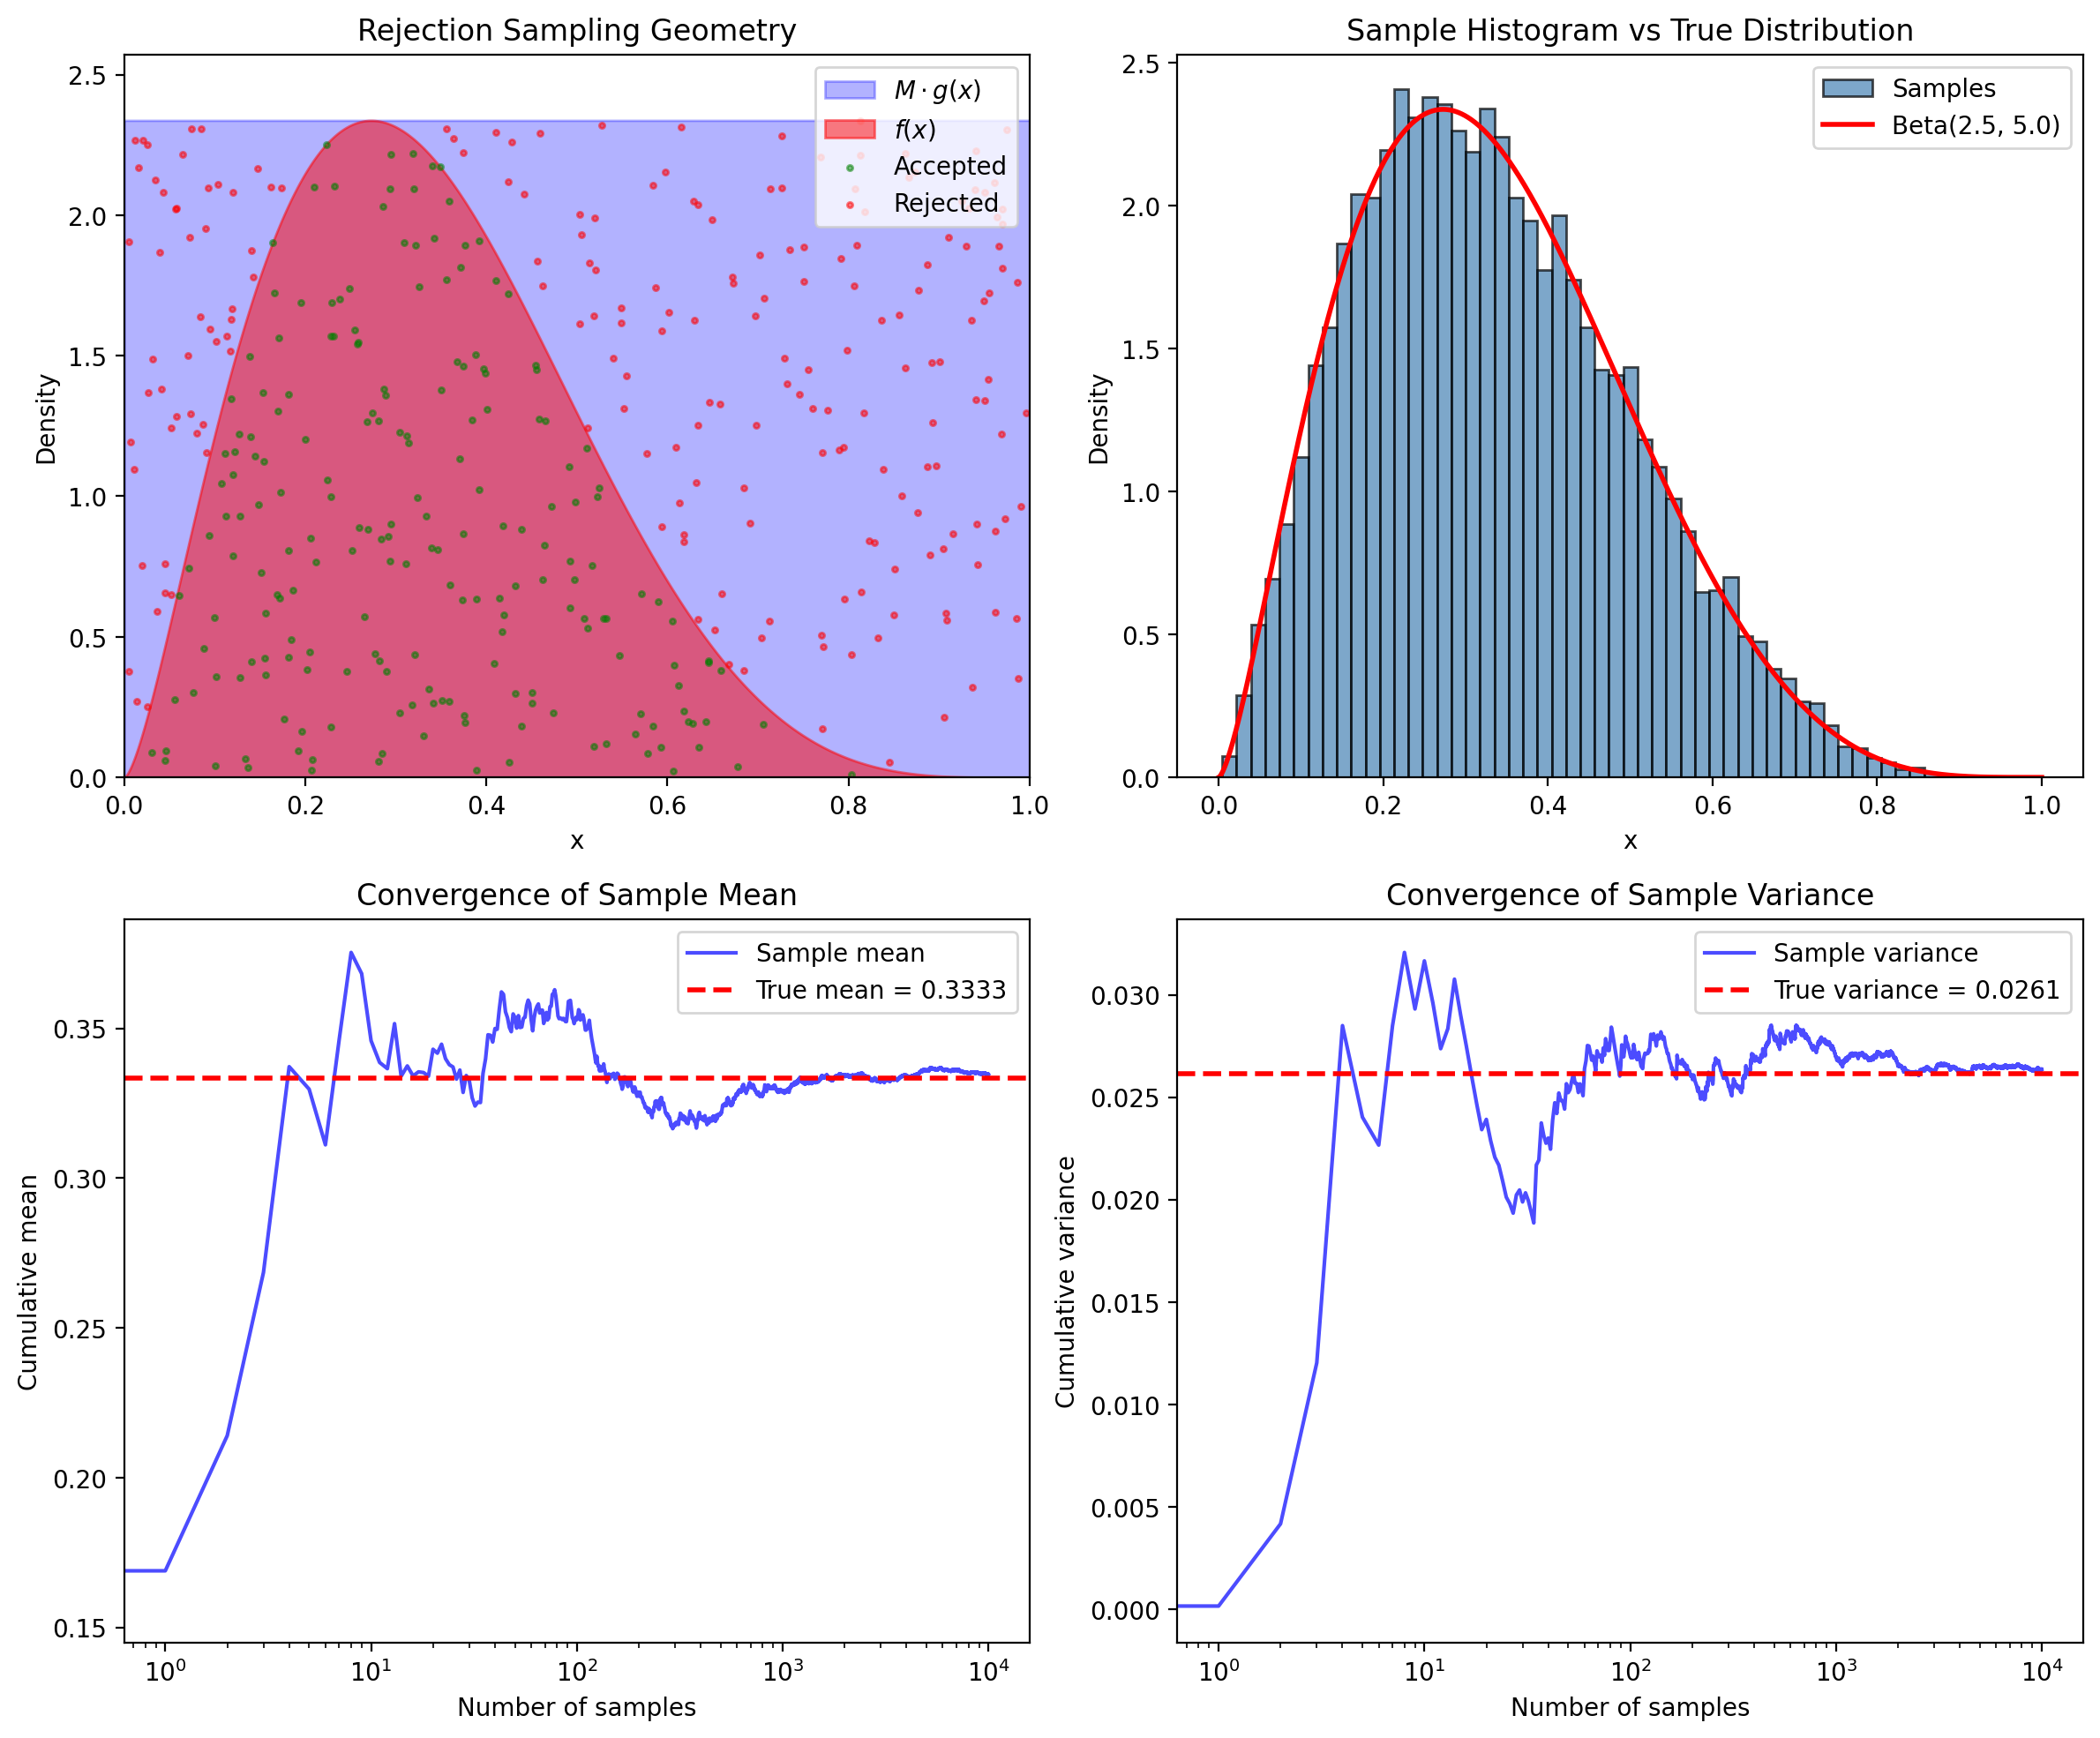


Plot saved to 'plot.png'


In [3]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Rejection sampling geometry
ax1 = axes[0, 0]
x_range = np.linspace(0, 1, 1000)
ax1.fill_between(x_range, 0, M * proposal_pdf(x_range), alpha=0.3, color='blue', label=r'$M \cdot g(x)$')
ax1.fill_between(x_range, 0, target_pdf(x_range), alpha=0.5, color='red', label=r'$f(x)$')

# Plot accepted and rejected points
if accepted_pts:
    acc_x, acc_y = zip(*accepted_pts[:200])
    ax1.scatter(acc_x, acc_y, s=5, c='green', alpha=0.5, label='Accepted')
if rejected_pts:
    rej_x, rej_y = zip(*rejected_pts[:200])
    ax1.scatter(rej_x, rej_y, s=5, c='red', alpha=0.5, label='Rejected')

ax1.set_xlabel('x')
ax1.set_ylabel('Density')
ax1.set_title('Rejection Sampling Geometry')
ax1.legend(loc='upper right')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, M * 1.1)

# Plot 2: Histogram vs true distribution
ax2 = axes[0, 1]
ax2.hist(samples, bins=50, density=True, alpha=0.7, color='steelblue', edgecolor='black', label='Samples')
ax2.plot(x_range, target_pdf(x_range), 'r-', lw=2, label=f'Beta({alpha}, {beta_param})')
ax2.set_xlabel('x')
ax2.set_ylabel('Density')
ax2.set_title('Sample Histogram vs True Distribution')
ax2.legend()

# Plot 3: Convergence of mean
ax3 = axes[1, 0]
cumulative_mean = np.cumsum(samples) / np.arange(1, n_samples + 1)
true_mean = alpha / (alpha + beta_param)
ax3.plot(cumulative_mean, 'b-', alpha=0.7, label='Sample mean')
ax3.axhline(y=true_mean, color='r', linestyle='--', lw=2, label=f'True mean = {true_mean:.4f}')
ax3.set_xlabel('Number of samples')
ax3.set_ylabel('Cumulative mean')
ax3.set_title('Convergence of Sample Mean')
ax3.legend()
ax3.set_xscale('log')

# Plot 4: Convergence of variance
ax4 = axes[1, 1]
cumulative_var = np.array([np.var(samples[:i+1]) for i in range(n_samples)])
true_var = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
ax4.plot(cumulative_var, 'b-', alpha=0.7, label='Sample variance')
ax4.axhline(y=true_var, color='r', linestyle='--', lw=2, label=f'True variance = {true_var:.4f}')
ax4.set_xlabel('Number of samples')
ax4.set_ylabel('Cumulative variance')
ax4.set_title('Convergence of Sample Variance')
ax4.legend()
ax4.set_xscale('log')

plt.tight_layout()
plt.savefig('rejection_sampling_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Statistical Validation

We perform statistical tests to verify that our samples are indeed drawn from the target distribution.

In [4]:
# Compare sample moments with theoretical moments
true_mean = alpha / (alpha + beta_param)
true_var = (alpha * beta_param) / ((alpha + beta_param)**2 * (alpha + beta_param + 1))
true_skewness = (2 * (beta_param - alpha) * np.sqrt(alpha + beta_param + 1)) / \
                ((alpha + beta_param + 2) * np.sqrt(alpha * beta_param))

sample_mean = np.mean(samples)
sample_var = np.var(samples)
sample_skewness = stats.skew(samples)

print("Moment Comparison:")
print("="*50)
print(f"{'Statistic':<20} {'True':>12} {'Sample':>12} {'Error':>12}")
print("-"*50)
print(f"{'Mean':<20} {true_mean:>12.6f} {sample_mean:>12.6f} {abs(true_mean - sample_mean):>12.6f}")
print(f"{'Variance':<20} {true_var:>12.6f} {sample_var:>12.6f} {abs(true_var - sample_var):>12.6f}")
print(f"{'Skewness':<20} {true_skewness:>12.6f} {sample_skewness:>12.6f} {abs(true_skewness - sample_skewness):>12.6f}")

# Kolmogorov-Smirnov test
ks_statistic, ks_pvalue = stats.kstest(samples, 'beta', args=(alpha, beta_param))
print(f"\nKolmogorov-Smirnov Test:")
print(f"  Statistic: {ks_statistic:.6f}")
print(f"  p-value: {ks_pvalue:.6f}")
print(f"  Result: {'Fail to reject H0 (samples match distribution)' if ks_pvalue > 0.05 else 'Reject H0'}")

Moment Comparison:
Statistic                    True       Sample        Error
--------------------------------------------------
Mean                     0.333333     0.334573     0.001240
Variance                 0.026144     0.026359     0.000215
Skewness                 0.434011     0.442792     0.008781

Kolmogorov-Smirnov Test:
  Statistic: 0.006262
  p-value: 0.825430
  Result: Fail to reject H0 (samples match distribution)


## Efficiency Analysis: Comparing Proposal Distributions

The efficiency of rejection sampling depends critically on how well the proposal distribution $g(x)$ approximates the target $f(x)$. We compare different proposal distributions.

In [5]:
# Compare efficiency with different proposals
def calculate_M_uniform():
    """Calculate M for uniform proposal."""
    x_mode = (alpha - 1) / (alpha + beta_param - 2)
    return target_pdf(x_mode)

def calculate_M_beta_approx():
    """Calculate M for Beta(2, 4) proposal (closer to target)."""
    # Using Beta(2, 4) as proposal
    alpha_prop, beta_prop = 2.0, 4.0
    x_test = np.linspace(0.001, 0.999, 10000)
    ratios = stats.beta.pdf(x_test, alpha, beta_param) / stats.beta.pdf(x_test, alpha_prop, beta_prop)
    return np.max(ratios)

M_uniform = calculate_M_uniform()
M_beta = calculate_M_beta_approx()

print("Efficiency Comparison:")
print("="*50)
print(f"{'Proposal Distribution':<25} {'M':>10} {'Acceptance Rate':>15}")
print("-"*50)
print(f"{'Uniform(0, 1)':<25} {M_uniform:>10.4f} {1/M_uniform:>15.4f}")
print(f"{'Beta(2, 4)':<25} {M_beta:>10.4f} {1/M_beta:>15.4f}")
print(f"\nUsing Beta(2, 4) is {M_uniform/M_beta:.2f}x more efficient than Uniform(0, 1)")

Efficiency Comparison:
Proposal Distribution              M Acceptance Rate
--------------------------------------------------
Uniform(0, 1)                 2.3370          0.4279
Beta(2, 4)                    1.1288          0.8859

Using Beta(2, 4) is 2.07x more efficient than Uniform(0, 1)


## Conclusions

This notebook demonstrated the rejection sampling algorithm, a fundamental Monte Carlo technique with the following key properties:

1. **Correctness**: The accepted samples provably follow the target distribution $f(x)$

2. **Simplicity**: The algorithm is easy to implement and understand

3. **Generality**: It works for any bounded density function

4. **Efficiency trade-offs**: The choice of proposal distribution $g(x)$ dramatically affects efficiency

### Limitations

- Requires finding a suitable envelope $M \cdot g(x) \geq f(x)$
- Can be inefficient in high dimensions (curse of dimensionality)
- The scaling constant $M$ may be difficult to determine for complex distributions

### Extensions

More advanced methods that build on rejection sampling include:
- **Adaptive rejection sampling** for log-concave densities
- **Importance sampling** which reweights samples instead of rejecting
- **Markov Chain Monte Carlo (MCMC)** methods for high-dimensional problems